In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

## Load and Inspect Data

In [2]:
data = pd.read_csv('conversion_data.csv')
print(data.shape)
data.head()

(316200, 6)


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [4]:
print('Columns\t\t Unique Value Counts\t\t Example')
for c in data.columns:
    uniques = sorted(data[c].unique())
    print('{0:20s} {1:15d} \t\t'.format(c, len(uniques)), uniques[:5])

Columns		 Unique Value Counts		 Example
country                            4 		 ['China', 'Germany', 'UK', 'US']
age                               60 		 [17, 18, 19, 20, 21]
new_user                           2 		 [0, 1]
source                             3 		 ['Ads', 'Direct', 'Seo']
total_pages_visited               29 		 [1, 2, 3, 4, 5]
converted                          2 		 [0, 1]


## Deal With Outliers

'age' column has max=123, which is obvious an outlier, so we need to handle it

In [5]:
data[data['age'] > 90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


There are only two records that is invalid, let's first remove them directly

In [6]:
data = data[data['age'] < 100]

## Explanatory Data Analysis

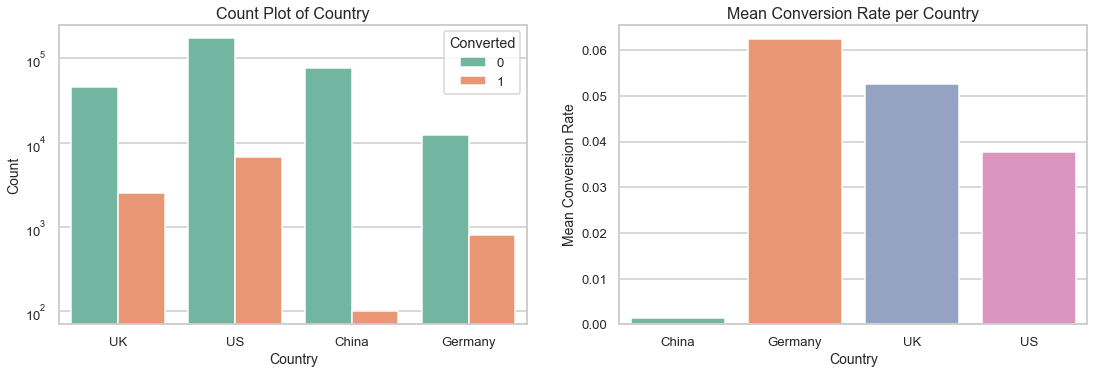

In [7]:
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

# set up the figure and subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# plot 1 - count plot of country with hue of converted
sns.countplot(x='country', hue='converted', data=data, ax=ax[0], palette='Set2')
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
ax[0].set_xlabel('Country', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].legend(title='Converted', loc='upper right')

# plot 2 - mean conversion rate per country
sns.barplot(x='country', y='converted', data=grouped, ax=ax[1], palette='Set2')
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
ax[1].set_xlabel('Country', fontsize=14)
ax[1].set_ylabel('Mean Conversion Rate', fontsize=14)

# adjust font size and style
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# adjust layout and spacing
fig.tight_layout(pad=3)

# display the plot
plt.show()

From the above plots, at least we can see two problems:

There are lot of users from China, but the conversion rate is lowest
Conversion rate in German is very high, but there aren't a lot of users from German

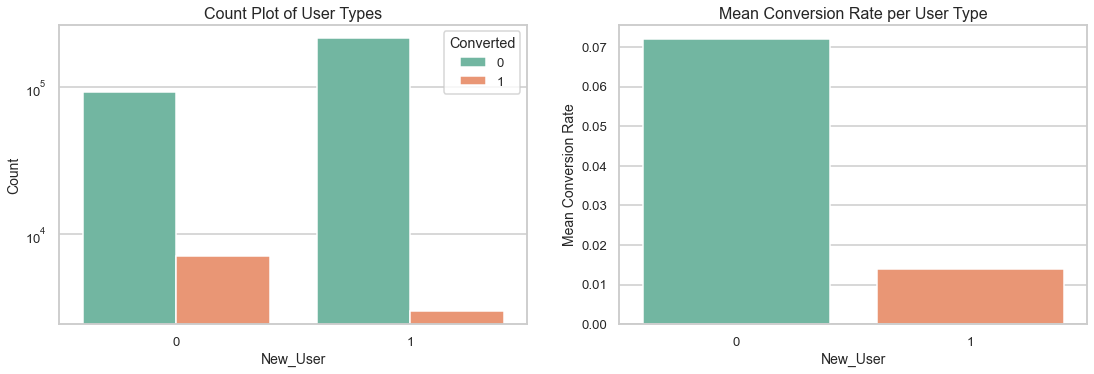

In [8]:
grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

# set up the figure and subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# plot 1 - count plot of user type with hue of converted
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0], palette='Set2')
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
ax[0].set_xlabel('New_User', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].legend(title='Converted', loc='upper right')

# plot 2 - mean conversion rate per user type
sns.barplot(x='new_user', y='converted', data=grouped, ax=ax[1], palette='Set2')
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
ax[1].set_xlabel('New_User', fontsize=14)
ax[1].set_ylabel('Mean Conversion Rate', fontsize=14)

# adjust font size and style
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# adjust layout and spacing
fig.tight_layout(pad=3)

# display the plot
plt.show()

Overall, new Users have a lower conversion rate than returning users

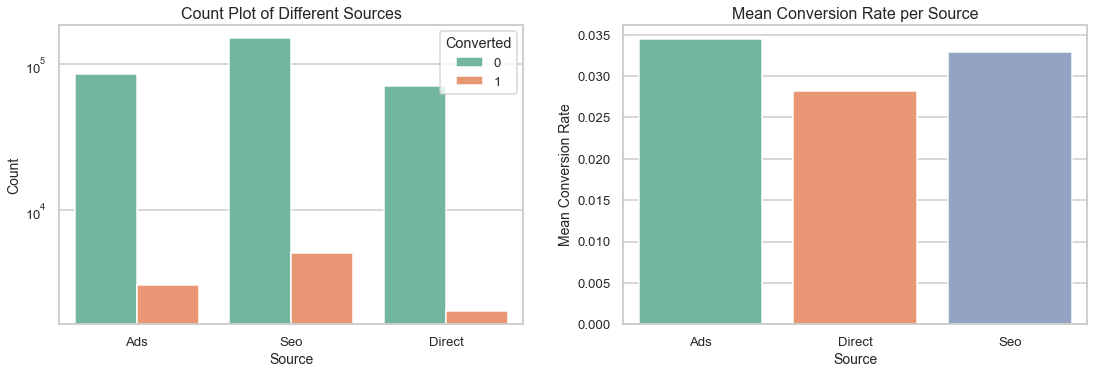

In [9]:
# Visualization of different sources
grouped = data[['source', 'converted']].groupby('source').mean().reset_index()

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

# set up the figure and subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# plot 1 - count plot of country with hue of converted
sns.countplot(x='source', hue='converted', data=data, ax=ax[0], palette='Set2')
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')
ax[0].set_xlabel('Source', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].legend(title='Converted', loc='upper right')

# plot 2 - mean conversion rate per country
sns.barplot(x='source', y='converted', data=grouped, ax=ax[1], palette='Set2')
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
ax[1].set_xlabel('Source', fontsize=14)
ax[1].set_ylabel('Mean Conversion Rate', fontsize=14)

# adjust font size and style
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# adjust layout and spacing
fig.tight_layout(pad=3)

# display the plot
plt.show()

All three sources have similar conversion performance, with Ads being the most effective one.

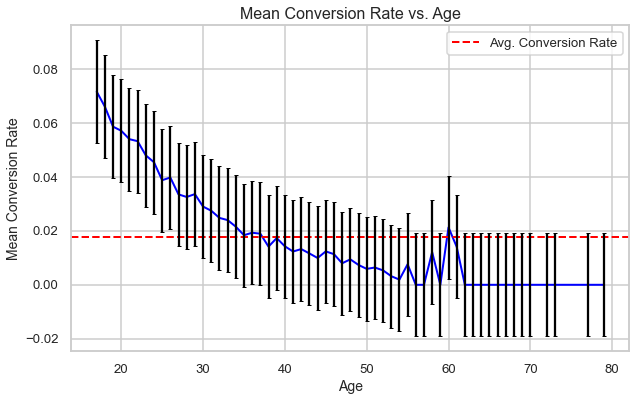

In [10]:
# create grouped data for mean conversion rate per age
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()

# set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# plot mean conversion rate vs. age
ax.plot(grouped['age'], grouped['converted'], color='blue', linestyle='-', linewidth=2)

# add horizontal line at average conversion rate
avg_conv_rate = np.mean(grouped['converted'])
ax.axhline(y=avg_conv_rate, color='red', linestyle='--', linewidth=2, label='Avg. Conversion Rate')

# add error bars
std_conv_rate = np.std(grouped['converted'])
ax.errorbar(grouped['age'], grouped['converted'], yerr=std_conv_rate, fmt='none', ecolor='black', capsize=2)

# set plot title and axis labels
ax.set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Mean Conversion Rate', fontsize=14)

# adjust font size and style
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# add legend and grid
ax.legend(loc='upper right')
ax.grid(True)

# display the plot
plt.show()

From above plot, we can see there is nearly no "conversion" from users which are older than 60

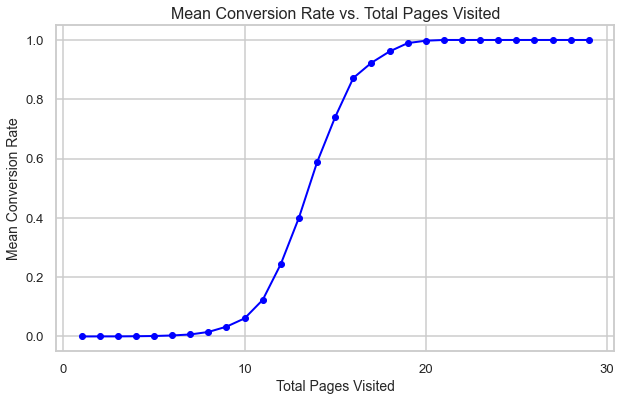

In [11]:
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
fig, ax = plt.subplots(figsize=(10, 6))

# plot mean conversion rate vs. total pages visited
ax.plot(grouped['total_pages_visited'], grouped['converted'], color='blue', linestyle='-', marker='o', markersize=6, linewidth=2)

# set plot title and axis labels
ax.set_title('Mean Conversion Rate vs. Total Pages Visited', fontsize=16)
ax.set_xlabel('Total Pages Visited', fontsize=14)
ax.set_ylabel('Mean Conversion Rate', fontsize=14)

# adjust font size and style
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# adjust tick labels on x-axis
ax.set_xticks([0, 10, 20, 30])
ax.set_xticklabels(['0', '10', '20', '30'])

# add grid
ax.grid(True)

# display the plot
plt.show()

## Label Encoding 

In [12]:
label_encoder = LabelEncoder()
data['country'] = label_encoder.fit_transform(data['country'])
data['source'] = label_encoder.fit_transform(data['source'])

In [13]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,2,25,1,0,1,0
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


## Model Building

Due to the imbalanced data structure which will influence the prediction result, I use under sample to reshape the data.

In [14]:
# under sampling - generate sample of class 0 types matching number of class 1 types

# calculate class counts
count0, count1 = data.converted.value_counts()

# separate classes
converted = data[data.converted==1]
non_converted = data[data.converted==0]

# perform under-sampling
under0 = non_converted.sample(count1, random_state=42)
model_dta = pd.concat([under0, converted], axis=0)

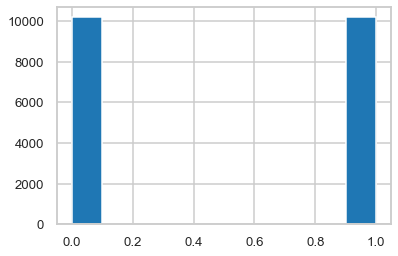

In [15]:
plt.hist(model_dta.converted)
plt.show()

Now the number of coverted and non-converted is equal

### Decision Tree Classifier

In [16]:
# use stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(model_dta.drop('converted', axis=1), model_dta.converted, test_size=0.2, random_state=42, stratify=model_dta.converted)

# train a model
dtree = DecisionTreeClassifier(max_depth=4, random_state=22)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

# evaluate performance using cross-validation
cv_scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring='accuracy')

# Print classification report
print(classification_report(y_test, y_pred))

# Evaluate performance using cross-validation
cv_scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring='accuracy')
print('Cross-validation accuracy scores:', cv_scores)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2040
           1       0.96      0.92      0.94      2040

    accuracy                           0.94      4080
   macro avg       0.94      0.94      0.94      4080
weighted avg       0.94      0.94      0.94      4080

Cross-validation accuracy scores: [0.93014706 0.92981918 0.93809378 0.92798039 0.92951272]


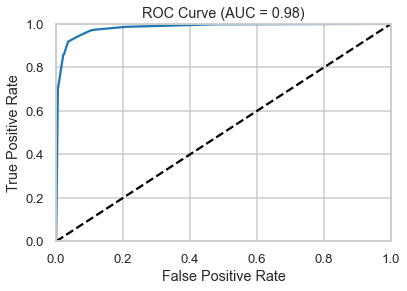

In [17]:
# predict class probabilities for test set
y_prob = dtree.predict_proba(X_test)[:, 1]

# calculate false positive rate and true positive rate at different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# calculate area under the curve
auc = roc_auc_score(y_test, y_prob)

# plot ROC curve
plt.plot(fpr, tpr)
plt.title('ROC Curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

### Random Forest Classifier 

In [18]:
# Create a Random Forest Classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rfc.fit(X_train, y_train)

# Predict on the test data
y_pred = rfc.predict(X_test)

# evaluate performance using cross-validation
cv_scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring='accuracy')

# Print classification report
print(classification_report(y_test, y_pred))

# Evaluate performance using cross-validation
cv_scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring='accuracy')
print('Cross-validation accuracy scores:', cv_scores)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2040
           1       0.93      0.94      0.93      2040

    accuracy                           0.93      4080
   macro avg       0.93      0.93      0.93      4080
weighted avg       0.93      0.93      0.93      4080

Cross-validation accuracy scores: [0.93014706 0.92981918 0.93809378 0.92798039 0.92951272]


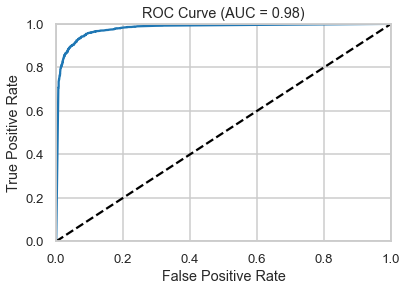

In [19]:
# predict class probabilities for test set
y_prob = rfc.predict_proba(X_test)[:, 1]

# calculate false positive rate and true positive rate at different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# calculate area under the curve
auc = roc_auc_score(y_test, y_prob)

# plot ROC curve
plt.plot(fpr, tpr)
plt.title('ROC Curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

I am going to pick a random forest to predict conversion rate. I pick a random forest cause: it usually requires very little time to optimize it (its default params are often close to the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. I will use the random forest to predict conversion, then I will use its variable importance to get insights about how it got information from the variables. Also, I will build a simple tree to find the most obvious user segments and see if they agree with RF partial dependence plots.

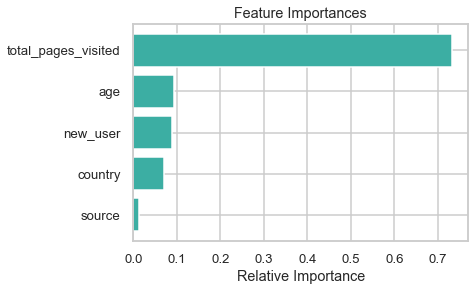

In [20]:
features = data.columns[:5]
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#3CAEA3', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Total pages visited is the most important one, by far. Unfortunately, it is probably the least “actionable”. People visit many pages cause they already want to buy. Also, in order to buy you have to click on multiple pages.

Let’s rebuild the RF without that variable.

### New Random Forest Classifier

In [21]:
# Create a Random Forest Classifier with 100 trees
rfc2 = RandomForestClassifier(n_estimators=100, random_state=42)

X_train_new = X_train.drop('total_pages_visited',axis=1)
X_test_new = X_test.drop('total_pages_visited',axis=1)

# Fit the model on the training data
rfc2.fit(X_train_new, y_train)

# Predict on the test data
y_pred = rfc2.predict(X_test_new)

# evaluate performance using cross-validation
cv_scores = cross_val_score(rfc2, X_train_new, y_train, cv=5, scoring='accuracy')

# Print classification report
print(classification_report(y_test, y_pred))

# Evaluate performance using cross-validation
cv_scores = cross_val_score(rfc2, X_train_new, y_train, cv=5, scoring='accuracy')
print('Cross-validation accuracy scores:', cv_scores)

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      2040
           1       0.75      0.73      0.74      2040

    accuracy                           0.74      4080
   macro avg       0.74      0.74      0.74      4080
weighted avg       0.74      0.74      0.74      4080

Cross-validation accuracy scores: [0.73560049 0.73184186 0.73521299 0.73398713 0.73551946]


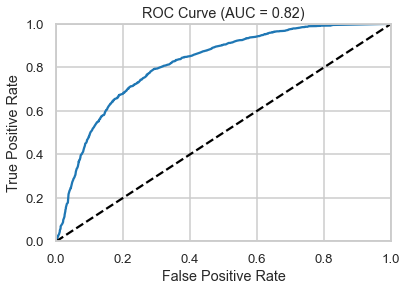

In [22]:
# predict class probabilities for test set
y_prob = rfc2.predict_proba(X_test_new)[:, 1]

# calculate false positive rate and true positive rate at different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# calculate area under the curve
auc = roc_auc_score(y_test, y_prob)

# plot ROC curve
plt.plot(fpr, tpr)
plt.title('ROC Curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

Accuracy went down, but that’s fine. The model is still good enough to give us insights.

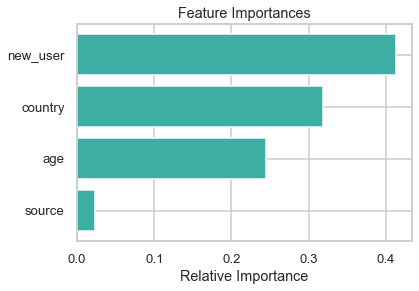

In [23]:
features = X_train_new.columns
importances = rfc2.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#3CAEA3', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Interesting! New user is the most important one. Source doesn’t seem to matter at all.

## Recommendation

### Demographic Features of Converted Users

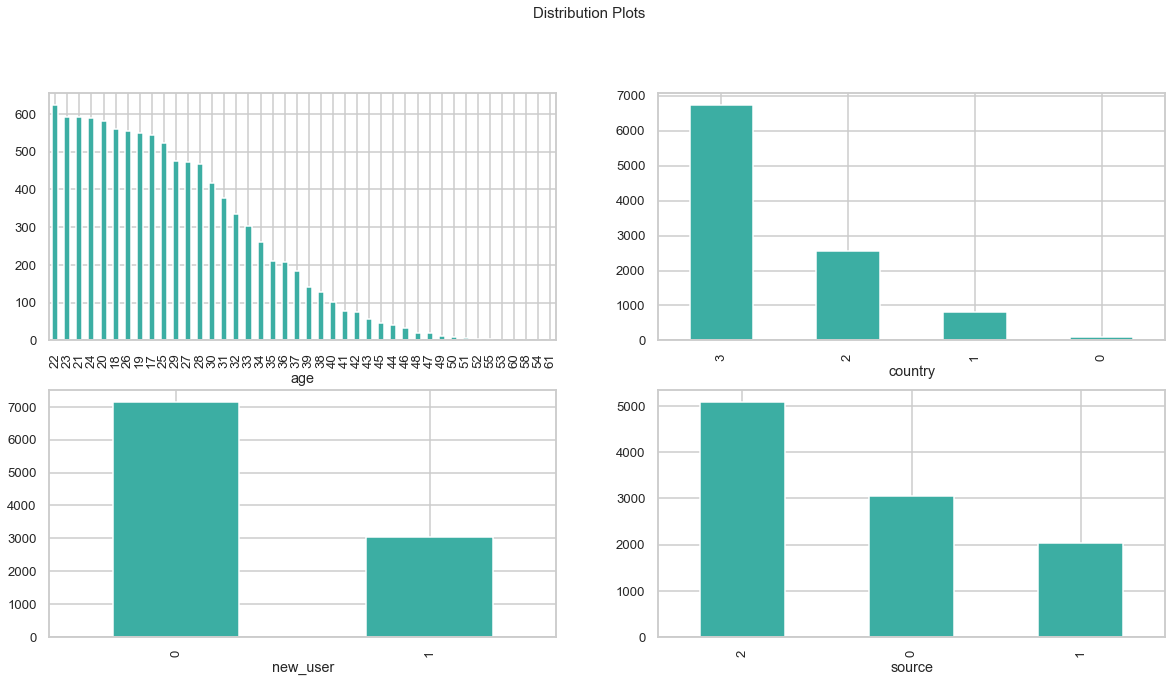

In [24]:
converted_user = data[data.converted == 1].drop('total_pages_visited', axis=1)

plt.subplots(figsize=(20,10))
i = 1
for y in ['age','country','new_user','source']:
    plt.subplot(2, 2, i)
    converted_user[y].value_counts().plot(kind='bar', color='#3CAEA3')
    plt.xlabel(y)
    i += 1
plt.suptitle('Distribution Plots', fontsize=15, y=1)
plt.show()

### Conclusion

Some conclusions and suggestions:

1. The site is working very well for young users. Definitely let’s tell marketing to advertise and use marketing channel which are more likely to reach young people.

2. The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.

3. Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.

4. Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, some payment issue or maybe it is just in English! Given how many users are based in China, fixing this should be a top priority. Huge opportunity.

5. Maybe go through the UI and figure out why older users perform so poorly? From 30 y/o conversion clearly starts dropping.

6. If I know someone has visited many pages, but hasn’t converted, she almost surely has high purchase intent. I could email her targeted offers or sending her reminders. Overall, these are probably the easiest users to make convert.